In [81]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import psycopg2
import csv
from nltk.corpus import stopwords
import ast
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
import re
import nltk
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline



In [100]:
# Connect to your PostgreSQL database
conn = psycopg2.connect(
    dbname="books",
    user="postgres",
    password="apple",
    host="localhost",   # use 'localhost' if it's your local machine
    port=5432    # default PostgreSQL port is 5432
)

cursor = conn.cursor()

# Updated query: Also select genre
query = """
SELECT books.book_id, books.name as title, authors.name as author, avg_rating, description, genre, books.image_link as url
FROM books, authors
WHERE books.author_id = authors.author_id - 1 order by books.name;
"""

# Execute the query
cursor.execute(query)

# Fetch all results
results = cursor.fetchall()

# Get column names
column_names = [desc[0] for desc in cursor.description]

# Index of the genre column (so we know where to modify)
genre_index = column_names.index('genre')

# Modify results: extract only the first genre
processed_results = []
for row in results:
    row = list(row)  # Convert tuple to list (so it's mutable)
    genre_str = row[genre_index]
    if genre_str:
        try:
            genre_list = ast.literal_eval(genre_str)
            if isinstance(genre_list, list) and genre_list:
                row[genre_index] = genre_list[0]
            else:
                row[genre_index] = None
        except Exception:
            row[genre_index] = None
    else:
        row[genre_index] = None
    processed_results.append(row)

# Write results to a CSV file
with open('books_with_authors.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(column_names)     # Write headers
    writer.writerows(processed_results)  # Write processed data

# Close the cursor and connection
cursor.close()
conn.close()

In [101]:
df = pd.read_csv("books_with_authors.csv")
df['description'] = df['description'].fillna('')
df.head()

,book_id,title,author,avg_rating,description,genre,url
0,229,11/22/63,STEPHEN KING,0.0,Stephen King’s #1 bestselling time-travel nove...,Fiction,https://images-na.ssl-images-amazon.com/images...
1,519,1Q84,HARUKI MURAKAMI,0.0,“Murakami is like a magician who explains what...,Fiction,https://images-na.ssl-images-amazon.com/images...
2,297,"20,000 Leagues Under the Sea",JULES VERNE,0.0,A huge sea monster has attacked and wrecked se...,Fiction,https://images-na.ssl-images-amazon.com/images...
3,441,A Bend in the Road,NICHOLAS SPARKS,0.0,Miles Ryan's life seemed to end the day his wi...,Romance,https://images-na.ssl-images-amazon.com/images...
4,350,A Brief History of Time,STEPHEN HAWKING,0.0,#1 NEW YORK TIMES BESTSELLER A landmark volume...,Nonfiction,https://images-na.ssl-images-amazon.com/images...


<Axes: xlabel='genre'>

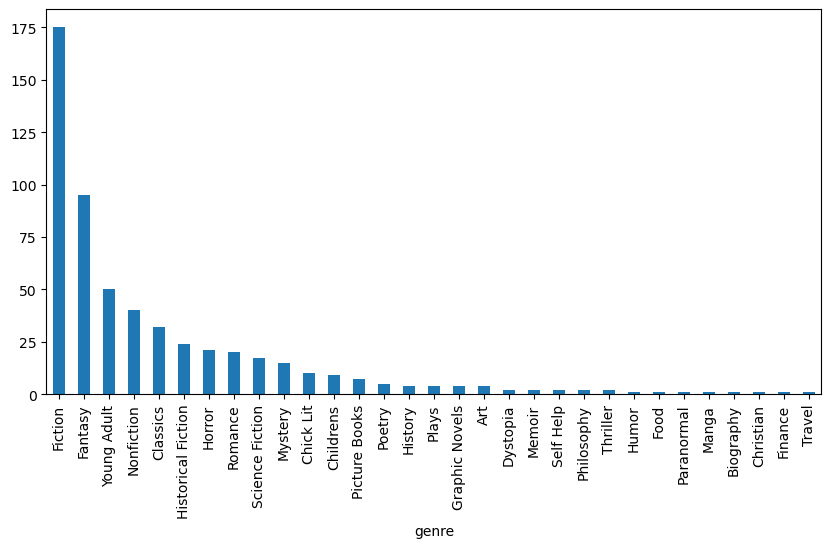

In [102]:
df['genre'].value_counts().plot(x = 'genre', y ='count', kind = 'bar', figsize = (10,5)  )

<Axes: title={'center': 'Word Count Distribution for book descriptions'}, ylabel='Frequency'>

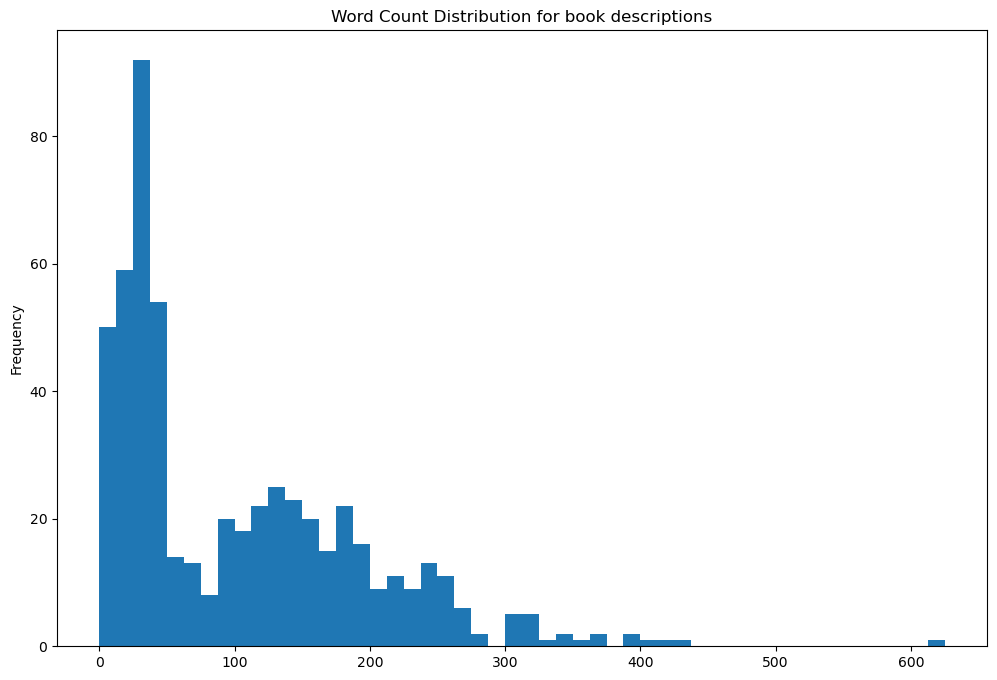

In [103]:
df['word_count'] = df['description'].apply(lambda x: len(str(x).split()))# Plotting the word count
df['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for book descriptions')



In [104]:
from textblob import TextBlob


<Axes: title={'center': 'Bigram disribution for the top 20 words in the book description'}, xlabel='bigram'>

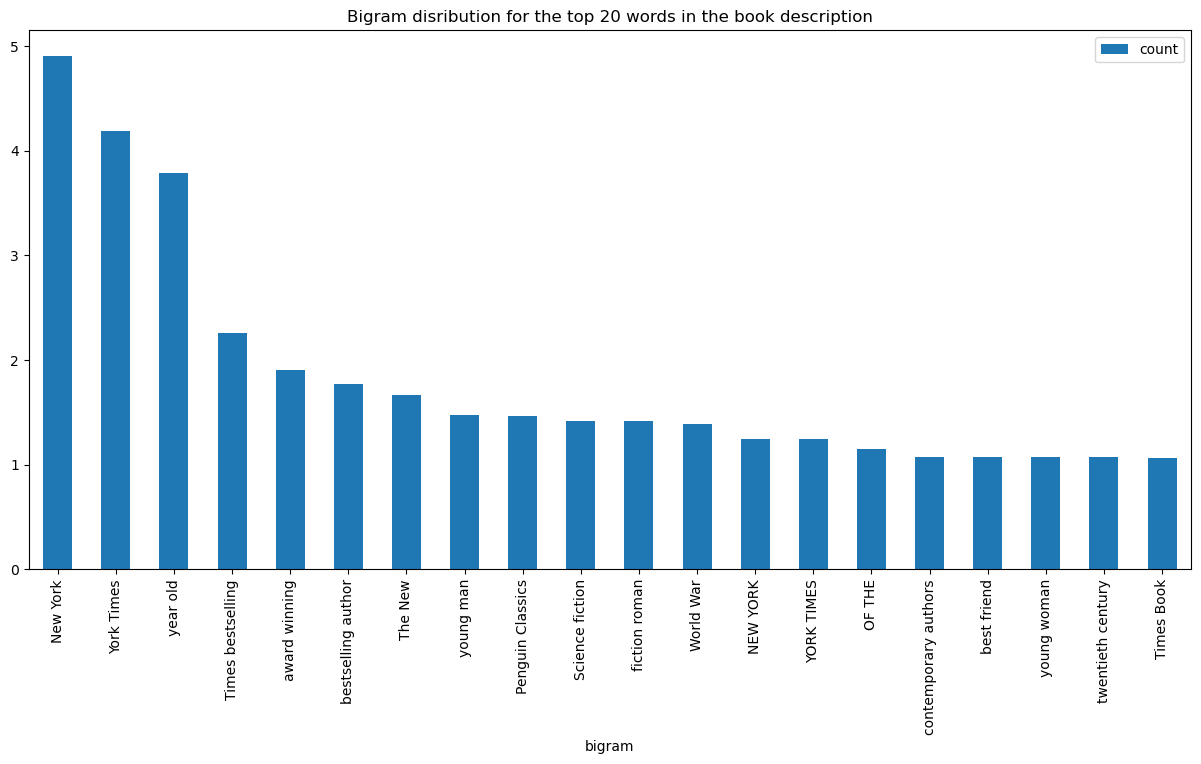

In [105]:
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['description'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )

<Axes: title={'center': 'Bigram disribution for the top 20 words in the book description'}, xlabel='trigram'>

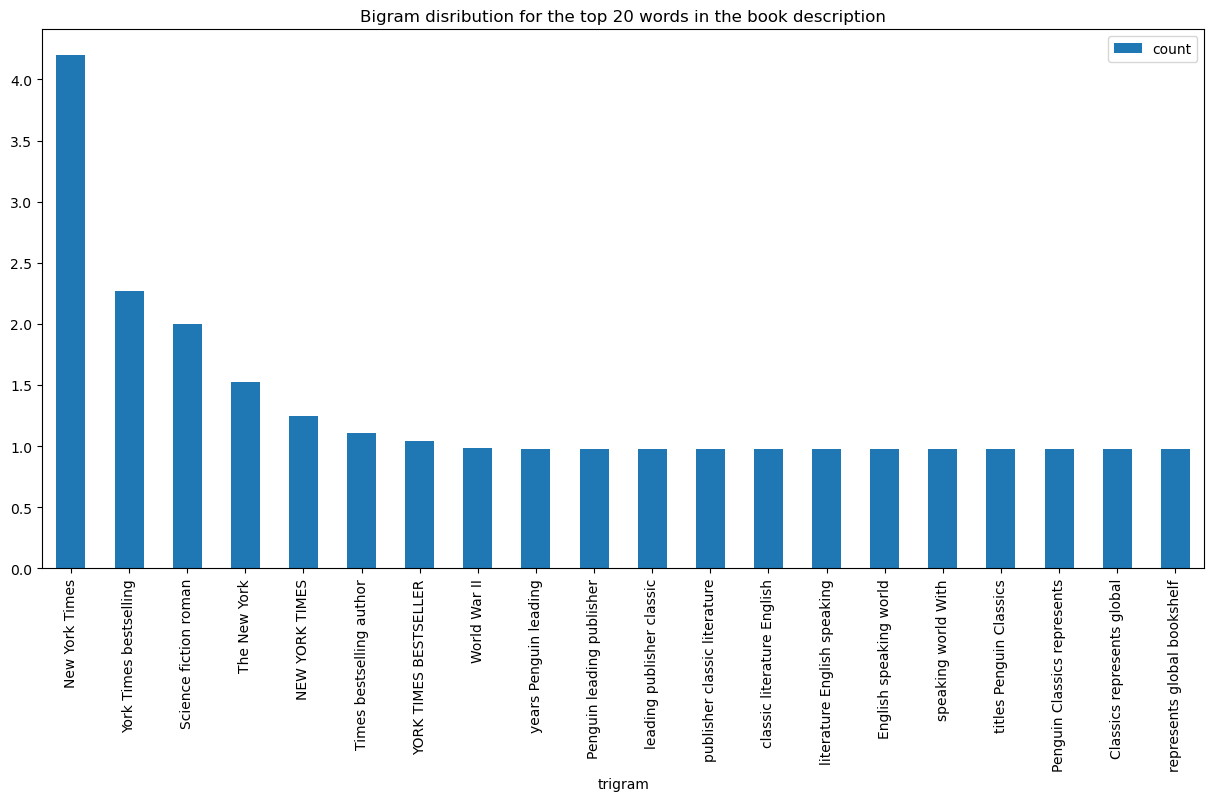

In [106]:
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(df['description'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the book description", figsize = (15,7), )


In [107]:
# Function for removing NonAscii characters
nltk.download('stopwords')
nltk.download('punkt')

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

# Function for converting into lower case
def make_lower_case(text):
    return text.lower()

# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

# Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

# Applying all the functions in description and storing as a cleaned_desc
df['cleaned_desc'] = df['description'].apply(_removeNonAscii)
df['cleaned_desc'] = df.cleaned_desc.apply(func = make_lower_case)
df['cleaned_desc'] = df.cleaned_desc.apply(func = remove_stop_words)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_punctuation)
df['cleaned_desc'] = df.cleaned_desc.apply(func=remove_html)

[nltk_data] Downloading package stopwords to /home/tony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [108]:
# Function for recommending books based on Book title. It takes book title and genre as an input.def recommend(title, genre):
def recommend(title, genre):
    # Matching the genre with the dataset and reset the index
    data = df.loc[df['genre'] == genre]  
    data = data[data['title'] != '']
    data.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title'])
    
    #Converting the book title into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['title'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]# Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))# Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)# Scores of the 5 most similar books 
    sig = sig[1:6]# Book indicies
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = data[['title', 'url']].iloc[movie_indices]
       
    # It reads the top 5 recommended book urls and print the images
    
    for i in rec['url']:
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img))


AxesImage(shape=(482, 314, 3))
AxesImage(shape=(630, 417, 3))
AxesImage(shape=(2531, 1650, 3))
AxesImage(shape=(1523, 915, 3))
AxesImage(shape=(475, 288, 3))


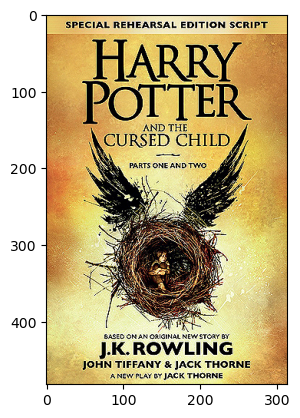

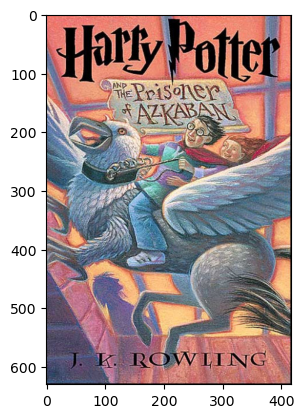

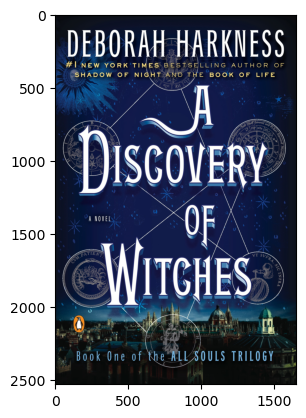

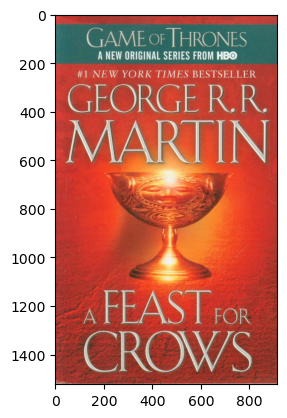

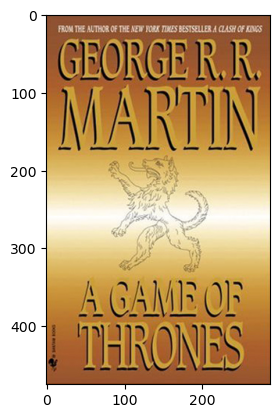

In [109]:
recommend("Harry Potter", "Fantasy")

In [118]:
def rec_desc(title, genre):
    global rec
    # Matching the genre with the dataset and reset the index
    data = df.loc[df['genre'] == genre]  
    data.reset_index(level = 0, inplace = True) 
  
    # Convert the index into series
    indices = pd.Series(data.index, index = data['title'])
    
    #Converting the book description into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['cleaned_desc'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title
       
    idx = indices[title]# Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))# Sort the books
    sig = sorted(sig, key=lambda x: x[1], reverse=True)# Scores of the 5 most similar books 
    sig = sig[1:6]# Book indicies
    movie_indices = [i[0] for i in sig]
   
    # Top 5 book recommendation
    rec = data[['title', 'book_id']].iloc[movie_indices]
    
    # It reads the top 5 recommend book url and print the images
    
    return rec['book_id']

In [119]:
rec_desc("The Hunger Games","Young Adult")

32    388
15    121
0      86
1     532
2      57
Name: book_id, dtype: int64

In [120]:
rec_desc("Norwegian Wood", "Fiction")

160    444
144    111
42     533
10      45
1      519
Name: book_id, dtype: int64

AxesImage(shape=(475, 313, 3))
AxesImage(shape=(453, 318, 3))
AxesImage(shape=(475, 312, 3))
AxesImage(shape=(500, 318, 3))
AxesImage(shape=(1014, 640, 3))


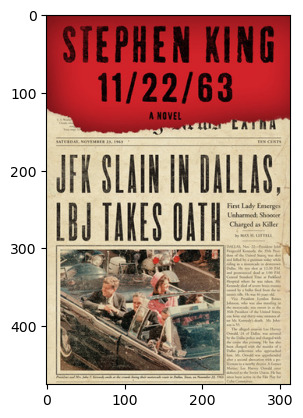

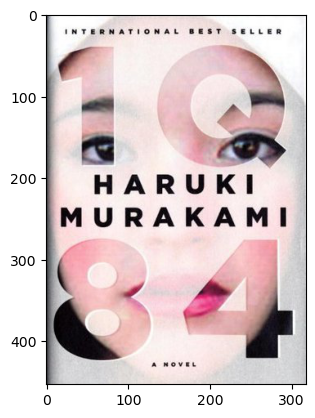

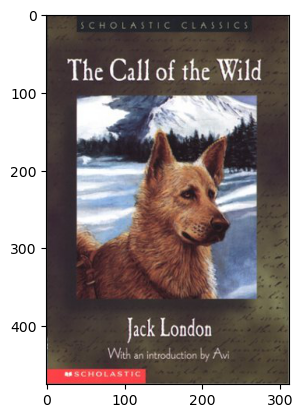

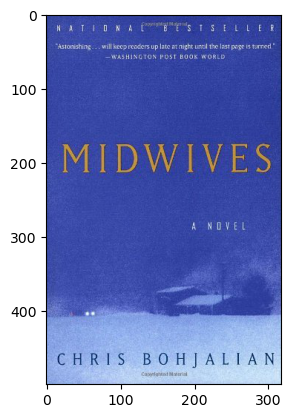

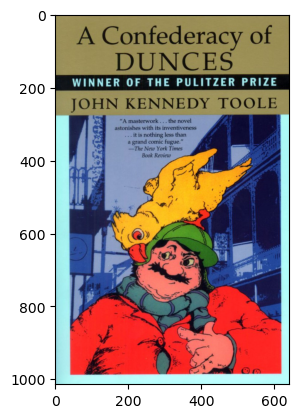

In [121]:
recommend("Norwegian Wood", "Fiction")